## Simple CNN

We are going to define a simple Convolutional Network and we are going to train it from scrath on the dataset. The results of this model is going to be our benchmark

We are going to use Keras library with tensorflow as a backend.

## Common configuration

In [1]:
IMAGE_SIZE = (360,404) # The dimensions to which all images found will be resized.
BATCH_SIZE = 32
NUMBER_EPOCHS = 8

TENSORBOARD_DIRECTORY = "../logs/simple_model/tensorboard"
TRAIN_DIRECTORY = "../data/train/"
VALID_DIRECTORY = "../data/valid/"
TEST_DIRECTORY = "../data/test/"

NUMBER_TRAIN_SAMPLES = 20000
NUMBER_VALIDATION_SAMPLES = 5000
NUMBER_TEST_SAMPLES = 2500

WEIGHTS_DIRECTORY = "../weights/"

Check that we are using the GPU:

In [2]:
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
    
get_available_gpus()

['/gpu:0']

In [6]:
import tensorflow as tf
# Creates a graph.
with tf.device('/gpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
  c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


## Model

### Model definition

In [7]:
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Input, Dense, Flatten

inputs = Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# First CNN Layer
x = Convolution2D(16, (3, 3), 
                  activation='relu', 
                  data_format="channels_last", 
                  kernel_initializer="he_uniform")(inputs)

x = MaxPooling2D(pool_size=(3, 3), 
                 strides=(2, 2), 
                 data_format="channels_last")(x)

# Second CNN Layer
x = Convolution2D(32, (3, 3), 
                  activation='relu', 
                  data_format="channels_last", 
                  kernel_initializer="he_uniform")(x)
x = MaxPooling2D(pool_size=(2, 2), 
                 strides=(2, 2), 
                 data_format="channels_last")(x)

# Third CNN Layer
x = Convolution2D(64, (3, 3), 
                  activation='relu', 
                  data_format="channels_last", 
                  kernel_initializer="he_uniform")(x)
x = MaxPooling2D(pool_size=(2, 2), 
                 strides=(2, 2), 
                 data_format="channels_last")(x)

# Third CNN Layer
x = Convolution2D(128, (3, 3), 
                  activation='relu', 
                  data_format="channels_last", 
                  kernel_initializer="he_uniform")(x)
x = MaxPooling2D(pool_size=(2, 2), 
                 strides=(2, 2), 
                 data_format="channels_last")(x)


x = Flatten()(x)

x = Dense(96, activation='relu',kernel_initializer="he_uniform")(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

Using TensorFlow backend.


### Model arquitecture

We have the following model arquitecture:

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 360, 404, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 358, 402, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 178, 200, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 176, 198, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 88, 99, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 86, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 43, 48, 64)        0         
__________

### Keras callbacks

We are going to define two callbacks that are going to be called in the training. EarlyStopping to stop the training if its not getting better. And a tensorboard callback to log information to be used by tensorboard.

In [9]:
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard

# Early stop in case of getting worse
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 0)

#TensorBoard
# run tensorboard with tensorboard --logdir=/full_path_to_your_logs
#tensorboard_path = TENSORBOARD_DIRECTORY
#tensorboard_logger = TensorBoard(log_dir=tensorboard_path, histogram_freq=0, write_graph=False, write_images=False)
#print('Logging basic info to be used by TensorBoard to {}. To see this log run:'.format(tensorboard_path))
#print('tensorboard --logdir={}'.format(tensorboard_path))

callbacks = [early_stop]#, tensorboard_logger]

### Model Optimizer

In [10]:
OPTIMIZER_LEARNING_RATE = 1e-2
OPTIMIZER_DECAY = 1e-4  # LearningRate = LearningRate * 1/(1 + decay * epoch)
OPTIMIZER_MOMENTUM = 0.89
OPTIMIZER_NESTEROV_ENABLED = False

In [11]:
from keras.optimizers import SGD

optimizer = SGD(lr=OPTIMIZER_LEARNING_RATE, 
          decay=OPTIMIZER_DECAY, 
          momentum=OPTIMIZER_MOMENTUM, 
          nesterov=OPTIMIZER_NESTEROV_ENABLED)

### Compile the model

In [12]:
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, \
              metrics=["accuracy"])

## Training 

### Train data generator

In [34]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

train_batch_generator =  train_datagen.flow_from_directory(TRAIN_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 17500 images belonging to 2 classes.


### Validation data generator

In [35]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
validation_datagen = ImageDataGenerator(rescale = 1./255)

valid_batch_generator =  validation_datagen.flow_from_directory(VALID_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 5000 images belonging to 2 classes.


### Model fitting

In [36]:
# fine-tune the model
hist = model.fit_generator(
        train_batch_generator,
        steps_per_epoch=NUMBER_TRAIN_SAMPLES/BATCH_SIZE,
        epochs=NUMBER_EPOCHS,  # epochs: Integer, total number of iterations on the data.
        validation_data=valid_batch_generator,
        validation_steps=NUMBER_VALIDATION_SAMPLES/BATCH_SIZE,
        callbacks=callbacks,
        verbose=2)

Epoch 1/8
577s - loss: 0.4319 - acc: 0.8023 - val_loss: 0.4202 - val_acc: 0.8218
Epoch 2/8
570s - loss: 0.3788 - acc: 0.8297 - val_loss: 0.3898 - val_acc: 0.8308
Epoch 3/8
568s - loss: 0.3440 - acc: 0.8520 - val_loss: 0.3758 - val_acc: 0.8426
Epoch 4/8
573s - loss: 0.3331 - acc: 0.8524 - val_loss: 0.3161 - val_acc: 0.8704
Epoch 5/8
571s - loss: 0.3096 - acc: 0.8642 - val_loss: 0.3334 - val_acc: 0.8566
Epoch 6/8
573s - loss: 0.2984 - acc: 0.8683 - val_loss: 0.3296 - val_acc: 0.8656
Epoch 7/8
574s - loss: 0.2775 - acc: 0.8822 - val_loss: 0.3033 - val_acc: 0.8672
Epoch 8/8
570s - loss: 0.2627 - acc: 0.8896 - val_loss: 0.3187 - val_acc: 0.8702


In [37]:

model_save_path = WEIGHTS_DIRECTORY + 'simple_cnn_weights.h5'

print('Saving TOP (FCN) weigths to ', model_save_path)

model.save_weights(model_save_path, overwrite=True)

Saving TOP (FCN) weigths to  ../weights/simple_cnn_weights.h5


### Training plots

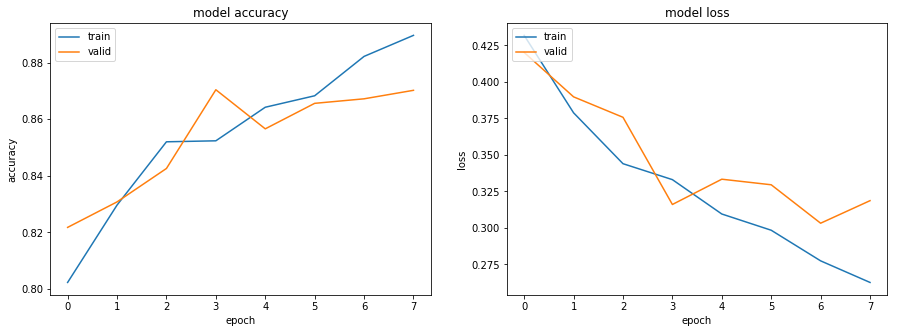

In [38]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()

## Plot a few examples

## Evaluate the model

In [13]:
############
# load weights
############
model_save_path = WEIGHTS_DIRECTORY + 'simple_cnn_weights.h5'
print("Loading weights from: {}".format(model_save_path))
model.load_weights(model_save_path)

Loading weights from: ../weights/simple_cnn_weights.h5


In [14]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
validation_datagen = ImageDataGenerator(rescale = 1./255)

test_batch_generator =  validation_datagen.flow_from_directory(TEST_DIRECTORY, 
                                                 target_size = IMAGE_SIZE,
                                                 class_mode = 'categorical', 
                                                 batch_size = BATCH_SIZE)

Found 2500 images belonging to 2 classes.


In [15]:
model.evaluate_generator(test_batch_generator,
                         steps = NUMBER_TEST_SAMPLES/BATCH_SIZE)

[0.17662325730323791, 0.93440000000000001]

## Test the model

In [16]:
from keras.preprocessing.image import ImageDataGenerator

## train generator with shuffle but no data augmentation
test_datagen = ImageDataGenerator(rescale = 1./255)

test_batch_generator = test_datagen.flow_from_directory(
                                TEST_DIRECTORY,
                                target_size = IMAGE_SIZE,
                                batch_size=1,
                                shuffle = False, # Important !!!
                                classes = None,
                                class_mode = None)

Found 2500 images belonging to 2 classes.


In [17]:
test_batch_generator.classes.shape

(2500,)

In [18]:
import pickle
test_classes_file = open("../results/simple_cnn_true.pickle", "wb" )
pickle.dump( test_batch_generator.classes, test_classes_file )

In [19]:
true_values = test_batch_generator.classes

In [20]:
len(test_batch_generator.filenames)

2500

In [21]:
test_filenames = open("../results/simple_cnn_filenames.pickle", "wb" )
pickle.dump( test_batch_generator.filenames, test_filenames )

In [25]:
import numpy as np

pred = []

for i in range(int(NUMBER_TEST_SAMPLES)):
    X = next(test_batch_generator)  # get the next batch
    #print(X.shape)
    pred1 = model.predict(X, batch_size = 1, verbose = 0) #predict on a batch
    pred = pred + pred1.tolist()

probabilities = np.array(pred)
print(probabilities.shape)
assert probabilities.shape == (NUMBER_TEST_SAMPLES, 2)

(2500, 2)


In [26]:
test_filenames = open("../results/simple_cnn_probabilities.pickle", "wb" )
pickle.dump( probabilities, test_filenames )

In [27]:
probabilities[0]

array([  9.99642730e-01,   3.57268873e-04])

In [28]:
predictions=np.argmax(probabilities,1)

In [29]:
test_filenames = open("../results/simple_cnn_predictions.pickle", "wb" )
pickle.dump( predictions, test_filenames )

In [30]:
predictions[0]

0

In [32]:
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1191   59]
 [ 105 1145]]


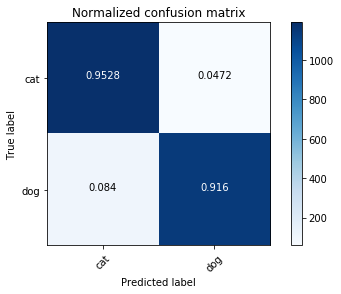

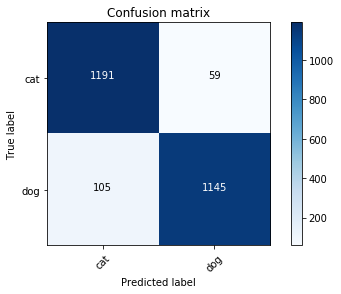

In [37]:
import itertools
from sklearn.metrics import confusion_matrix

class_names = ['cat', 'dog']
cnf_matrix = confusion_matrix(true_values, predictions)
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

In [49]:
from numpy.random import random, permutation
#1. A few correct labels at random
correct = np.where(predictions==true_values)[0]

idx = permutation(correct)[:4]
#plots_idx(idx, probs[idx])

In [50]:
len(correct)

2336

In [57]:
type(int(idx[0]))

int

In [51]:
from scipy import ndimage
from PIL import Image
import matplotlib.pyplot as plt

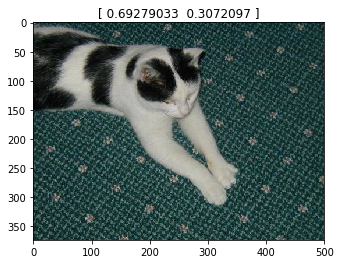

In [59]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[0]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[0]])
plt.show()

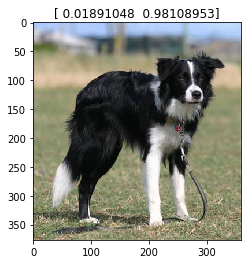

In [61]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[1]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[1]])
plt.show()

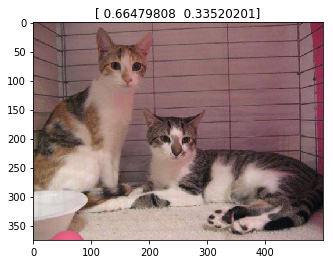

In [62]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[2]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[2]])
plt.show()

In [63]:
from numpy.random import random, permutation
#1. A few correct labels at random
correct = np.where(predictions != true_values)[0]

idx = permutation(correct)[:4]
#plots_idx(idx, probs[idx])

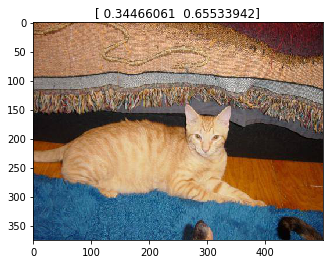

In [64]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[0]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[0]])
plt.show()

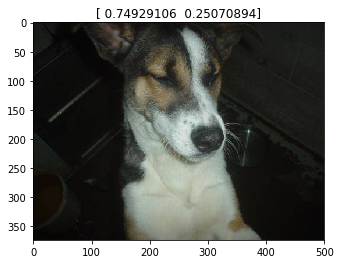

In [66]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[1]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[1]])
plt.show()

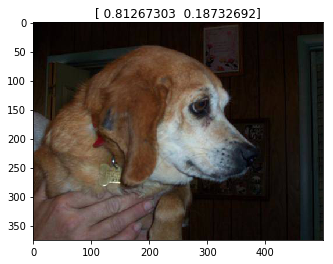

In [67]:
im = ndimage.imread("../data/test/" + test_batch_generator.filenames[idx[2]])
image = Image.fromarray(im)
plt.imshow(image)
plt.title(probabilities[idx[2]])
plt.show()